In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
cd /content/drive/MyDrive/Question Pair Similarity Classification

/content/drive/MyDrive/Question Pair Similarity Classification


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# Load datasets
train_df = pd.read_csv("/content/drive/MyDrive/Question Pair Similarity Classification/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Question Pair Similarity Classification/test.csv")

<ipython-input-5-e80d836c74a9>:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv("/content/drive/MyDrive/Question Pair Similarity Classification/test.csv")


In [6]:
# Drop missing values
train_df.dropna(inplace=True)

In [7]:
# Exploratory Data Analysis
print(train_df.head())
print(train_df.info())
print(train_df["is_duplicate"].value_counts())

   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  
<class 'pandas.core.frame.DataFrame'>
Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  

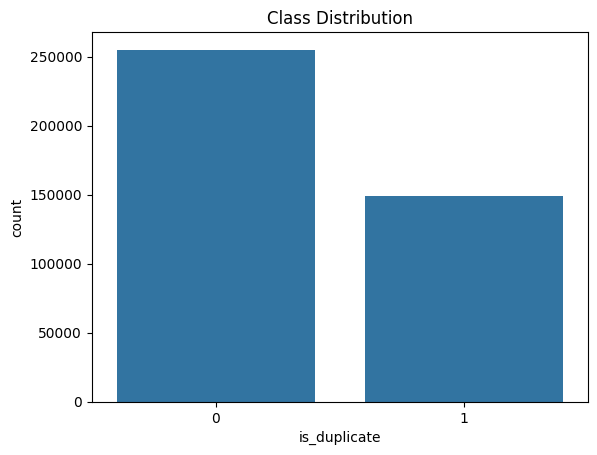

In [8]:
# Visualizing class distribution
sns.countplot(x=train_df["is_duplicate"])
plt.title("Class Distribution")
plt.show()

In [9]:
# Text Preprocessing
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
# Precompute stopwords for efficiency
stop_words = set(stopwords.words('english'))

def clean_text_fast(text_series):
    return (
        text_series.str.lower()
        .str.replace(r'[^a-zA-Z0-9]', ' ', regex=True)
        .str.split()
        .apply(lambda words: ' '.join([word for word in words if word not in stop_words]))
    )

# Apply vectorized function
train_df[['question1', 'question2']] = train_df[['question1', 'question2']].astype(str).apply(clean_text_fast)
test_df[['question1', 'question2']] = test_df[['question1', 'question2']].astype(str).apply(clean_text_fast)


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Assuming 'train_df' contains training data
# Extract features using TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(train_df['question1'] + ' ' + train_df['question2']) # Combine questions for context

# Define your target variable
y = train_df['is_duplicate']

# Now you can perform the train-test split
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [12]:
# Baseline Model: Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_val)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Logistic Regression Accuracy: 0.7510697766454772
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.82     51026
           1       0.72      0.53      0.61     29832

    accuracy                           0.75     80858
   macro avg       0.74      0.71      0.71     80858
weighted avg       0.75      0.75      0.74     80858



In [14]:
# Create TF-IDF features for the test set
X_test_tfidf = vectorizer.transform(test_df['question1'] + ' ' + test_df['question2'])

# Predict on the test set using the created TF-IDF features
test_df['is_duplicate'] = logreg.predict(X_test_tfidf)

In [15]:
# Deep Learning Model (LSTM)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['question1'].tolist() + train_df['question2'].tolist())
X1_seq = tokenizer.texts_to_sequences(train_df['question1'])
X2_seq = tokenizer.texts_to_sequences(train_df['question2'])
X1_pad = pad_sequences(X1_seq, maxlen=50)
X2_pad = pad_sequences(X2_seq, maxlen=50)
X_nn = np.concatenate((X1_pad, X2_pad), axis=1)

X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_nn, y, test_size=0.2, random_state=42)

In [16]:
# Define LSTM Model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=100),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# Train Model
model.fit(X_train_nn, y_train_nn, epochs=3, batch_size=256, validation_data=(X_val_nn, y_val_nn))

Epoch 1/3
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.7011 - loss: 0.5762 - val_accuracy: 0.7592 - val_loss: 0.4908
Epoch 2/3
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 81s 33ms/step - accuracy: 0.7832 - loss: 0.4552 - val_accuracy: 0.7752 - val_loss: 0.4686
Epoch 3/3
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.8223 - loss: 0.3827 - val_accuracy: 0.7737 - val_loss: 0.4855


In [19]:
# Evaluation
y_pred_nn = (model.predict(X_val_nn) > 0.5).astype(int)
print("Deep Learning Model Accuracy:", accuracy_score(y_val_nn, y_pred_nn))
print("Classification Report:\n", classification_report(y_val_nn, y_pred_nn))

2527/2527 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step
Deep Learning Model Accuracy: 0.7736525761211012
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82     51026
           1       0.68      0.72      0.70     29832

    accuracy                           0.77     80858
   macro avg       0.76      0.76      0.76     80858
weighted avg       0.78      0.77      0.77     80858



In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd # Import pandas

# Load datasets if they haven't been loaded yet
try:
    train_df
except NameError:
    train_df = pd.read_csv("/content/drive/MyDrive/Question Pair Similarity Classification/train.csv")
try:
    test_df
except NameError:
    test_df = pd.read_csv("/content/drive/MyDrive/Question Pair Similarity Classification/test.csv")
# Tokenize once for all data
tokenizer = Tokenizer()
texts = train_df['question1'].tolist() + train_df['question2'].tolist()
tokenizer.fit_on_texts(texts)

# Convert test questions to sequences
X_test_seq = tokenizer.texts_to_sequences(test_df['question1'].tolist() + test_df['question2'].tolist())

# Pad sequences
X_test_pad = pad_sequences(X_test_seq, maxlen=50)

# Reshape test data properly
X1_test_pad, X2_test_pad = X_test_pad[:len(test_df)], X_test_pad[len(test_df):]

# Predict in batches to prevent memory issues
batch_size = 1024
predictions = model.predict([X1_test_pad, X2_test_pad], batch_size=batch_size)

# Store predictions
test_df['is_duplicate'] = (predictions > 0.5).astype(int)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(1024, 50))', 'Tensor(shape=(1024, 50))')
  warnings.warn(msg)


3476/3480 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(None, 50))', 'Tensor(shape=(None, 50))')
  warnings.warn(msg)


3480/3480 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step


In [29]:
# Save predictions

original_test_df = pd.read_csv("/content/drive/MyDrive/Question Pair Similarity Classification/test.csv")


test_df['test_id'] = original_test_df['test_id']

# save to CSV, use 'test_id'
test_df[['test_id', 'is_duplicate']].to_csv("submission.csv", index=False)

<ipython-input-29-e351f449eef9>:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  original_test_df = pd.read_csv("/content/drive/MyDrive/Question Pair Similarity Classification/test.csv")


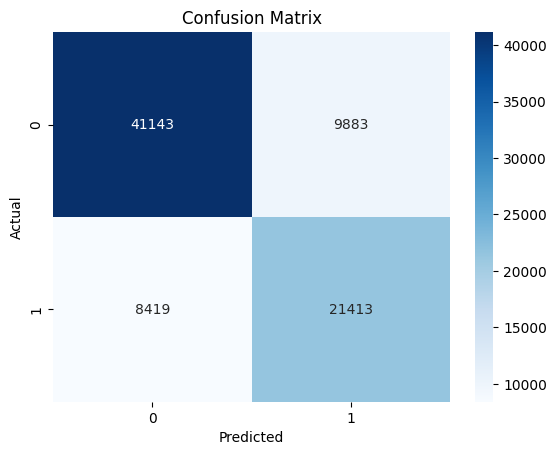

In [30]:
# Plot Confusion Matrix
cm = confusion_matrix(y_val_nn, y_pred_nn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()